In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
with open('config.json') as config_file:
    config = json.load(config_file)

In [3]:
EPOCHS = config["source_epochs"]
LR = 1e-4
IN_SHAPE = config["image_shape"]
MAGNIFICATION = config["magnification"]
N_MAG = config["n_magnification"]
center_disp, center_scale, amp_scale, amp_disp = config["lens_centers_disp"], config["lens_centers_scale"], config["lens_amp_scale"], config["lens_amp_disp"]
resolution = config["resolution"]/(MAGNIFICATION*N_MAG)
source_scaling = config["source_scaling"]

In [4]:
BATCH_SIZE = 5
dataset = data.LensingDataset('/home/anirudh/Documents/GSoC/LensSR/Simulations/data_model_1/',['no_sub_sie_noise'],5000)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

In [5]:
i_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["i_depth"], in_channels=1, latent_channel_count=config["i_latent_channels"]).to(device)
s_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["s_depth"], in_channels=1, latent_channel_count=config["i_latent_channels"]).to(device)

alpha = torch.tensor(np.load('/home/anirudh/Documents/GSoC/LensSR/Simulations/data_model_1/no_sub_sie/alpha.npy')).to(device).type(torch.float32)
phy_loss = models.LensingLoss(in_shape=IN_SHAPE*MAGNIFICATION*N_MAG,device=device,alpha=alpha, resolution=resolution, BATCH_SIZE=BATCH_SIZE, source_scaling=source_scaling).to(device)

opt = torch.optim.Adam(params=s_model.parameters(),lr=LR)
total_params = sum(p.numel() for p in s_model.parameters())
print(f"Number of parameters: {total_params}x2")

Number of parameters: 899843x2


In [6]:
def give_random_image(dataset, model1, model2, length):
    """
    To display a random image for illustration

    :param dataset: Dataset used
    :param model: Model used
    :param length: Length of dataset used
    :return: original LR image, SR image, original HR image
    """
    i = np.random.randint(low=0,high=length)
    LR = dataset[i]
    t = LR.clone().detach().view(1,1,IN_SHAPE,IN_SHAPE)
    t1 = model1(t.float().to(device)).cpu().detach()
    t2 = model2(t.float().to(device)).cpu().detach()
    image1 = Image.fromarray(t1.numpy()[0][0]*255)
    image2 = Image.fromarray(t2.numpy()[0][0]*255)
    image3, image4 = phy_loss.get_samples(t1.to(device))
    return (Image.fromarray(t.numpy()[0][0]*255), image1, image2, Image.fromarray(image3.cpu().numpy()[0][0]*255), Image.fromarray(image4.cpu().numpy()[0][0]*255))

def show_random_image(image_tuple):
    image0, image1, image2, image3, image4 = image_tuple[0], image_tuple[1], image_tuple[2], image_tuple[3], image_tuple[4]
    plot, axes = plt.subplots(1,5)
    plot.set_size_inches(30,6)
    axes[0].imshow(image0)
    axes[1].imshow(image1)
    axes[2].imshow(image2)
    axes[3].imshow(image3)
    axes[4].imshow(image4)
    axes[0].set_title("LR")
    axes[1].set_title("Image")
    axes[2].set_title("Source_network")
    axes[3].set_title("Source_regenerated")
    axes[4].set_title("Source_true")

In [7]:
i_model.load_state_dict(torch.load('bicubic.pt'))

<All keys matched successfully>

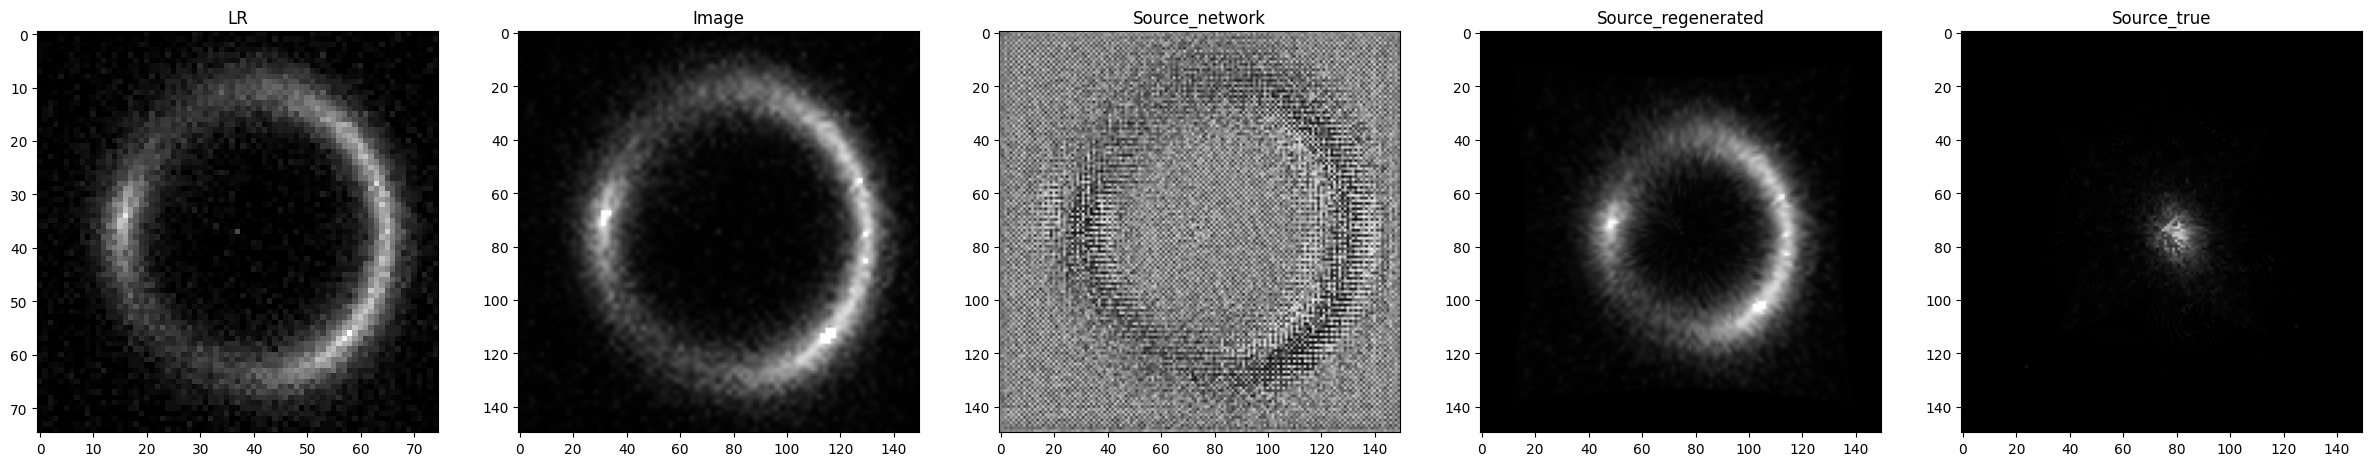

In [8]:
show_random_image(give_random_image(val_dataset, i_model, s_model, len(val_dataset)))

In [9]:
best_val_loss = np.inf
best_weights = None
history = {'pre_loss':[],'val_loss':[], 'loss':[]}
for epoch in range(EPOCHS):
    losses = []
    i_model.eval()
    s_model.train()
    for i,(x) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x) = (x.float().to(device))
        image = i_model(x)
        source = s_model(x)
        loss = phy_loss(source, image, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses))
    i_model.eval()
    s_model.eval()
    losses = []
    for i,(x) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch+1}")):
        (x) = (x.float().to(device))
        image = i_model(x)
        source = s_model(x)
        # k_tensor = k_model(x)
        val_loss = phy_loss(source, image, x)
        losses.append(float(val_loss))
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = s_model.state_dict()
    history['val_loss'].append(np.mean(losses))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} at LR={opt.param_groups[0]['lr']}")

Training epoch 1: 100%|██████████| 800/800 [01:05<00:00, 12.22it/s]


Training at epoch 1/50: 0.292157569359988 at LR=0.0001


Validation epoch 1: 100%|██████████| 200/200 [00:06<00:00, 33.31it/s]


Validation at epoch 1/50: 0.27301044315099715 at LR=0.0001


Training epoch 2: 100%|██████████| 800/800 [01:05<00:00, 12.13it/s]


Training at epoch 2/50: 0.25506040526553986 at LR=0.0001


Validation epoch 2: 100%|██████████| 200/200 [00:05<00:00, 33.47it/s]


Validation at epoch 2/50: 0.240110417753458 at LR=0.0001


Training epoch 3: 100%|██████████| 800/800 [01:06<00:00, 12.09it/s]


Training at epoch 3/50: 0.22631270829588174 at LR=0.0001


Validation epoch 3: 100%|██████████| 200/200 [00:05<00:00, 33.37it/s]


Validation at epoch 3/50: 0.20510515227913856 at LR=0.0001


Training epoch 4: 100%|██████████| 800/800 [01:06<00:00, 12.06it/s]


Training at epoch 4/50: 0.20059661842882634 at LR=0.0001


Validation epoch 4: 100%|██████████| 200/200 [00:06<00:00, 33.25it/s]


Validation at epoch 4/50: 0.19527597136795521 at LR=0.0001


Training epoch 5: 100%|██████████| 800/800 [01:06<00:00, 12.03it/s]


Training at epoch 5/50: 0.17758452620357276 at LR=0.0001


Validation epoch 5: 100%|██████████| 200/200 [00:06<00:00, 33.04it/s]


Validation at epoch 5/50: 0.16593137331306934 at LR=0.0001


Training epoch 6: 100%|██████████| 800/800 [01:06<00:00, 12.01it/s]


Training at epoch 6/50: 0.15688621966168284 at LR=0.0001


Validation epoch 6: 100%|██████████| 200/200 [00:06<00:00, 32.97it/s]


Validation at epoch 6/50: 0.15073241099715232 at LR=0.0001


Training epoch 7: 100%|██████████| 800/800 [01:06<00:00, 12.00it/s]


Training at epoch 7/50: 0.1382544893026352 at LR=0.0001


Validation epoch 7: 100%|██████████| 200/200 [00:06<00:00, 32.87it/s]


Validation at epoch 7/50: 0.12536971643567085 at LR=0.0001


Training epoch 8: 100%|██████████| 800/800 [01:06<00:00, 12.00it/s]


Training at epoch 8/50: 0.12161002976819874 at LR=0.0001


Validation epoch 8: 100%|██████████| 200/200 [00:06<00:00, 33.03it/s]


Validation at epoch 8/50: 0.10997123844921589 at LR=0.0001


Training epoch 9: 100%|██████████| 800/800 [01:06<00:00, 11.99it/s]


Training at epoch 9/50: 0.10670311696827411 at LR=0.0001


Validation epoch 9: 100%|██████████| 200/200 [00:06<00:00, 32.97it/s]


Validation at epoch 9/50: 0.09953273557126523 at LR=0.0001


Training epoch 10: 100%|██████████| 800/800 [01:06<00:00, 11.97it/s]


Training at epoch 10/50: 0.09339683191850781 at LR=0.0001


Validation epoch 10: 100%|██████████| 200/200 [00:06<00:00, 33.07it/s]


Validation at epoch 10/50: 0.08555737536400557 at LR=0.0001


Training epoch 11: 100%|██████████| 800/800 [01:06<00:00, 11.97it/s]


Training at epoch 11/50: 0.08153326482512056 at LR=0.0001


Validation epoch 11: 100%|██████████| 200/200 [00:06<00:00, 32.94it/s]


Validation at epoch 11/50: 0.08613963160663843 at LR=0.0001


Training epoch 12: 100%|██████████| 800/800 [01:06<00:00, 11.98it/s]


Training at epoch 12/50: 0.0709880759799853 at LR=0.0001


Validation epoch 12: 100%|██████████| 200/200 [00:06<00:00, 32.94it/s]


Validation at epoch 12/50: 0.06823105290532112 at LR=0.0001


Training epoch 13: 100%|██████████| 800/800 [01:06<00:00, 11.97it/s]


Training at epoch 13/50: 0.061622012229636314 at LR=0.0001


Validation epoch 13: 100%|██████████| 200/200 [00:06<00:00, 33.18it/s]


Validation at epoch 13/50: 0.05715659886598587 at LR=0.0001


Training epoch 14: 100%|██████████| 800/800 [01:06<00:00, 11.97it/s]


Training at epoch 14/50: 0.05344973450526595 at LR=0.0001


Validation epoch 14: 100%|██████████| 200/200 [00:06<00:00, 32.94it/s]


Validation at epoch 14/50: 0.045687854290008545 at LR=0.0001


Training epoch 15: 100%|██████████| 800/800 [01:06<00:00, 11.97it/s]


Training at epoch 15/50: 0.046200898699462416 at LR=0.0001


Validation epoch 15: 100%|██████████| 200/200 [00:06<00:00, 32.96it/s]


Validation at epoch 15/50: 0.03899040304124355 at LR=0.0001


Training epoch 16: 100%|██████████| 800/800 [01:06<00:00, 11.97it/s]


Training at epoch 16/50: 0.03982141466345638 at LR=0.0001


Validation epoch 16: 100%|██████████| 200/200 [00:06<00:00, 32.87it/s]


Validation at epoch 16/50: 0.040965606607496735 at LR=0.0001


Training epoch 17: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 17/50: 0.03425904997391626 at LR=0.0001


Validation epoch 17: 100%|██████████| 200/200 [00:06<00:00, 32.78it/s]


Validation at epoch 17/50: 0.034390456955879924 at LR=0.0001


Training epoch 18: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 18/50: 0.029402307090349494 at LR=0.0001


Validation epoch 18: 100%|██████████| 200/200 [00:06<00:00, 32.97it/s]


Validation at epoch 18/50: 0.02618709092028439 at LR=0.0001


Training epoch 19: 100%|██████████| 800/800 [01:06<00:00, 11.97it/s]


Training at epoch 19/50: 0.025179561898112296 at LR=0.0001


Validation epoch 19: 100%|██████████| 200/200 [00:06<00:00, 32.87it/s]


Validation at epoch 19/50: 0.023114311806857586 at LR=0.0001


Training epoch 20: 100%|██████████| 800/800 [01:06<00:00, 11.97it/s]


Training at epoch 20/50: 0.0214997510088142 at LR=0.0001


Validation epoch 20: 100%|██████████| 200/200 [00:06<00:00, 32.87it/s]


Validation at epoch 20/50: 0.016860983483493328 at LR=0.0001


Training epoch 21: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 21/50: 0.01833445483702235 at LR=0.0001


Validation epoch 21: 100%|██████████| 200/200 [00:06<00:00, 32.87it/s]


Validation at epoch 21/50: 0.018274575490504503 at LR=0.0001


Training epoch 22: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 22/50: 0.015598525020759552 at LR=0.0001


Validation epoch 22: 100%|██████████| 200/200 [00:06<00:00, 33.06it/s]


Validation at epoch 22/50: 0.012975888531655074 at LR=0.0001


Training epoch 23: 100%|██████████| 800/800 [01:06<00:00, 11.97it/s]


Training at epoch 23/50: 0.013237693522823975 at LR=0.0001


Validation epoch 23: 100%|██████████| 200/200 [00:06<00:00, 32.79it/s]


Validation at epoch 23/50: 0.012530465386807918 at LR=0.0001


Training epoch 24: 100%|██████████| 800/800 [01:06<00:00, 11.97it/s]


Training at epoch 24/50: 0.011247517057927325 at LR=0.0001


Validation epoch 24: 100%|██████████| 200/200 [00:06<00:00, 32.90it/s]


Validation at epoch 24/50: 0.011067314804531634 at LR=0.0001


Training epoch 25: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 25/50: 0.009531288447906263 at LR=0.0001


Validation epoch 25: 100%|██████████| 200/200 [00:06<00:00, 33.03it/s]


Validation at epoch 25/50: 0.00831227920949459 at LR=0.0001


Training epoch 26: 100%|██████████| 800/800 [01:06<00:00, 11.97it/s]


Training at epoch 26/50: 0.008082850457285531 at LR=0.0001


Validation epoch 26: 100%|██████████| 200/200 [00:06<00:00, 32.91it/s]


Validation at epoch 26/50: 0.005864051671233028 at LR=0.0001


Training epoch 27: 100%|██████████| 800/800 [01:06<00:00, 11.97it/s]


Training at epoch 27/50: 0.006841890530777164 at LR=0.0001


Validation epoch 27: 100%|██████████| 200/200 [00:06<00:00, 32.95it/s]


Validation at epoch 27/50: 0.005772154291626066 at LR=0.0001


Training epoch 28: 100%|██████████| 800/800 [01:06<00:00, 11.97it/s]


Training at epoch 28/50: 0.0058108556093066 at LR=0.0001


Validation epoch 28: 100%|██████████| 200/200 [00:06<00:00, 32.77it/s]


Validation at epoch 28/50: 0.005183206193614751 at LR=0.0001


Training epoch 29: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 29/50: 0.004942022241302766 at LR=0.0001


Validation epoch 29: 100%|██████████| 200/200 [00:06<00:00, 32.81it/s]


Validation at epoch 29/50: 0.004214382382342592 at LR=0.0001


Training epoch 30: 100%|██████████| 800/800 [01:06<00:00, 11.97it/s]


Training at epoch 30/50: 0.004202527783054393 at LR=0.0001


Validation epoch 30: 100%|██████████| 200/200 [00:06<00:00, 32.90it/s]


Validation at epoch 30/50: 0.0035697253549005835 at LR=0.0001


Training epoch 31: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 31/50: 0.003596752281009685 at LR=0.0001


Validation epoch 31: 100%|██████████| 200/200 [00:06<00:00, 32.85it/s]


Validation at epoch 31/50: 0.002568261323031038 at LR=0.0001


Training epoch 32: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 32/50: 0.003109045430319384 at LR=0.0001


Validation epoch 32: 100%|██████████| 200/200 [00:06<00:00, 32.96it/s]


Validation at epoch 32/50: 0.002766660439083353 at LR=0.0001


Training epoch 33: 100%|██████████| 800/800 [01:06<00:00, 11.97it/s]


Training at epoch 33/50: 0.0027131162004661747 at LR=0.0001


Validation epoch 33: 100%|██████████| 200/200 [00:06<00:00, 32.94it/s]


Validation at epoch 33/50: 0.00317747708177194 at LR=0.0001


Training epoch 34: 100%|██████████| 800/800 [01:06<00:00, 11.97it/s]


Training at epoch 34/50: 0.0023830029311648106 at LR=0.0001


Validation epoch 34: 100%|██████████| 200/200 [00:06<00:00, 32.79it/s]


Validation at epoch 34/50: 0.0020268904283875597 at LR=0.0001


Training epoch 35: 100%|██████████| 800/800 [01:06<00:00, 11.97it/s]


Training at epoch 35/50: 0.0021554534359893296 at LR=0.0001


Validation epoch 35: 100%|██████████| 200/200 [00:06<00:00, 33.06it/s]


Validation at epoch 35/50: 0.0028920245135668665 at LR=0.0001


Training epoch 36: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 36/50: 0.0019735692323592955 at LR=0.0001


Validation epoch 36: 100%|██████████| 200/200 [00:06<00:00, 33.11it/s]


Validation at epoch 36/50: 0.002340777083300054 at LR=0.0001


Training epoch 37: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 37/50: 0.0017496113399101886 at LR=0.0001


Validation epoch 37: 100%|██████████| 200/200 [00:06<00:00, 32.92it/s]


Validation at epoch 37/50: 0.002084655137732625 at LR=0.0001


Training epoch 38: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 38/50: 0.0016925057688786183 at LR=0.0001


Validation epoch 38: 100%|██████████| 200/200 [00:06<00:00, 32.91it/s]


Validation at epoch 38/50: 0.0016790111240698024 at LR=0.0001


Training epoch 39: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 39/50: 0.0015430288716743235 at LR=0.0001


Validation epoch 39: 100%|██████████| 200/200 [00:06<00:00, 33.08it/s]


Validation at epoch 39/50: 0.001433626234647818 at LR=0.0001


Training epoch 40: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 40/50: 0.0014980445489345584 at LR=0.0001


Validation epoch 40: 100%|██████████| 200/200 [00:06<00:00, 32.91it/s]


Validation at epoch 40/50: 0.0015369059378281236 at LR=0.0001


Training epoch 41: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 41/50: 0.001449563837813912 at LR=0.0001


Validation epoch 41: 100%|██████████| 200/200 [00:06<00:00, 33.00it/s]


Validation at epoch 41/50: 0.001288332591066137 at LR=0.0001


Training epoch 42: 100%|██████████| 800/800 [01:06<00:00, 11.97it/s]


Training at epoch 42/50: 0.0013574160654388834 at LR=0.0001


Validation epoch 42: 100%|██████████| 200/200 [00:06<00:00, 33.02it/s]


Validation at epoch 42/50: 0.0012367284132051282 at LR=0.0001


Training epoch 43: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 43/50: 0.0013463805259380025 at LR=0.0001


Validation epoch 43: 100%|██████████| 200/200 [00:06<00:00, 32.82it/s]


Validation at epoch 43/50: 0.0012940692872507498 at LR=0.0001


Training epoch 44: 100%|██████████| 800/800 [01:06<00:00, 11.97it/s]


Training at epoch 44/50: 0.0013248415297130124 at LR=0.0001


Validation epoch 44: 100%|██████████| 200/200 [00:06<00:00, 32.84it/s]


Validation at epoch 44/50: 0.0012997704051667825 at LR=0.0001


Training epoch 45: 100%|██████████| 800/800 [01:06<00:00, 11.97it/s]


Training at epoch 45/50: 0.0013057487056357786 at LR=0.0001


Validation epoch 45: 100%|██████████| 200/200 [00:06<00:00, 32.85it/s]


Validation at epoch 45/50: 0.0014104087970918044 at LR=0.0001


Training epoch 46: 100%|██████████| 800/800 [01:06<00:00, 11.97it/s]


Training at epoch 46/50: 0.0012529463047394529 at LR=0.0001


Validation epoch 46: 100%|██████████| 200/200 [00:06<00:00, 33.03it/s]


Validation at epoch 46/50: 0.0011658178229117767 at LR=0.0001


Training epoch 47: 100%|██████████| 800/800 [01:06<00:00, 11.97it/s]


Training at epoch 47/50: 0.0012481088654021733 at LR=0.0001


Validation epoch 47: 100%|██████████| 200/200 [00:06<00:00, 33.07it/s]


Validation at epoch 47/50: 0.0011639446904882788 at LR=0.0001


Training epoch 48: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 48/50: 0.0012238509330200031 at LR=0.0001


Validation epoch 48: 100%|██████████| 200/200 [00:06<00:00, 32.82it/s]


Validation at epoch 48/50: 0.001151677409070544 at LR=0.0001


Training epoch 49: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 49/50: 0.0012359643066156424 at LR=0.0001


Validation epoch 49: 100%|██████████| 200/200 [00:06<00:00, 32.87it/s]


Validation at epoch 49/50: 0.0011402492204797454 at LR=0.0001


Training epoch 50: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 50/50: 0.001219899151910795 at LR=0.0001


Validation epoch 50: 100%|██████████| 200/200 [00:06<00:00, 32.95it/s]

Validation at epoch 50/50: 0.0011969463247805835 at LR=0.0001


In [10]:
s_model.load_state_dict(best_weights)
torch.save(s_model.state_dict(),'s_weight.pt')

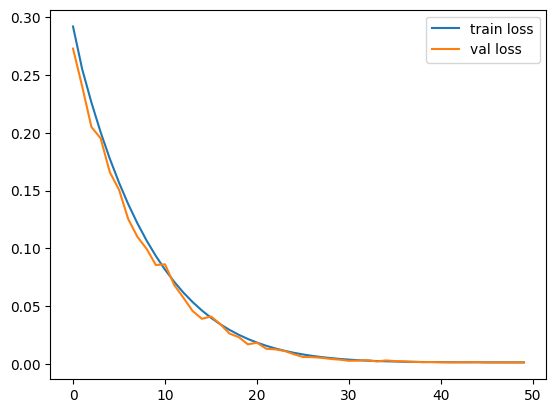

In [11]:
plt.plot(history['loss'],label='train loss')
plt.plot(history['val_loss'],label='val loss')
plt.legend()

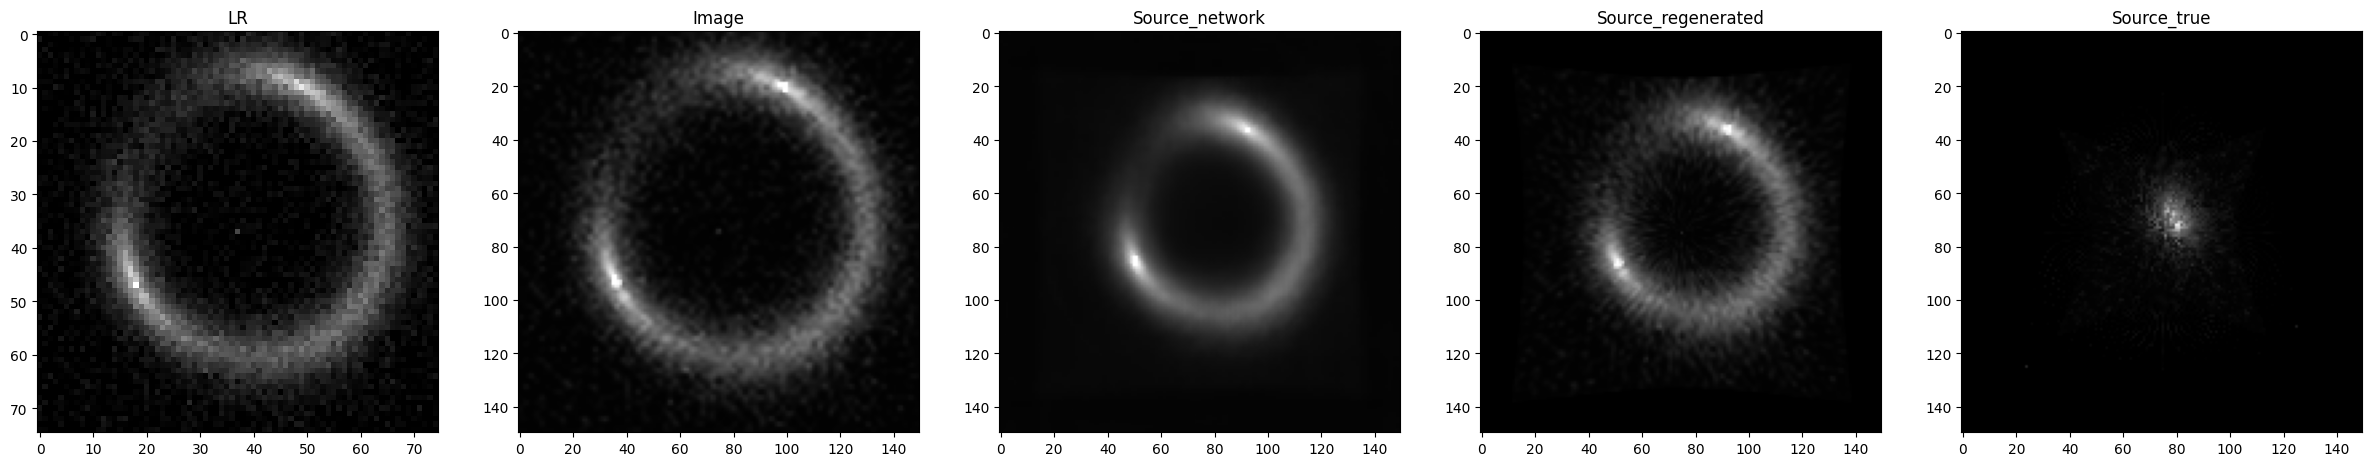

In [12]:
show_random_image(give_random_image(val_dataset, i_model, s_model, len(val_dataset)))